-姓名:黄彪
-学号:19550510015

# 影视作品与评分之间的关系

In [ ]:
-自回归模型
-移动回归模型

数据读取和预测

In [51]:
import warnings
warnings.filterwarnings("ignore")

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

In [53]:
data = pd.read_csv('C:/Users/30505/Desktop/HBO_MAX_Content.csv')
data.head()

,title,type,year,rating,imdb_score,rotten_score,decade,imdb_bucket,genres_Action_Adventure,genres_Animation,...,platforms_shudder,platforms_starz,platforms_sundancenow,platforms_syfy_tveverywhere,platforms_tbs,platforms_tnt,platforms_trutv_tveverywhere,platforms_urbanmoviechannel,platforms_velocity_go,platforms_watch_tcm
0,Game of Thrones,TV,2011,R/TV-MA,9.3,89.0,2010-2019,9.01-9.50,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Rick and Morty,TV,2013,R/TV-MA,9.2,94.0,2010-2019,9.01-9.50,1,1,...,0,0,0,0,0,0,0,0,0,0
2,The Lord of the Rings: The Fellowship of the Ring,NaN,2001,PG-13/TV-14,8.8,91.0,2000-2009,8.51-9.00,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Fight Club,NaN,1999,R/TV-MA,8.8,79.0,1990-1999,8.51-9.00,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Lord of the Rings: The Two Towers,NaN,2002,PG-13/TV-14,8.7,95.0,2000-2009,8.51-9.00,1,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
data.dtypes

title                            object
type                             object
year                              int64
rating                           object
imdb_score                      float64
                                 ...   
platforms_tnt                     int64
platforms_trutv_tveverywhere      int64
platforms_urbanmoviechannel       int64
platforms_velocity_go             int64
platforms_watch_tcm               int64
Length: 75, dtype: object

索引的数据类型

In [56]:
data.index

RangeIndex(start=0, stop=2087, step=1)

检验评分的波动

In [71]:
ts = data['imdb_score']
ts.head(100)

0     9.3
1     9.2
2     8.8
3     8.8
4     8.7
     ... 
95    7.9
96    8.1
97    7.6
98    7.8
99    7.4
Name: imdb_score, Length: 100, dtype: float64

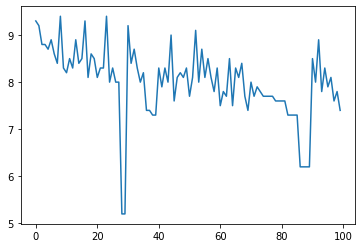

In [58]:
plt.plot(ts.head(100))

测试稳定性

In [59]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean =timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print( 'Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

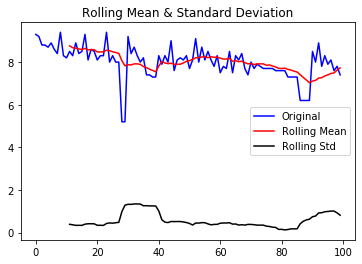

Results of Dickey-Fuller Test:
Test Statistic                -5.920294e+00
p-value                        2.515799e-07
#Lags Used                     0.000000e+00
Number of Observations Used    9.900000e+01
Critical Value (1%)           -3.498198e+00
Critical Value (5%)           -2.891208e+00
Critical Value (10%)          -2.582596e+00
dtype: float64


In [60]:
test_stationarity(ts.head(100))

均值显然随集数增加，并且这不是平稳序列。同样，测试统计量远不止临界值。

# 指数加权移动平均法

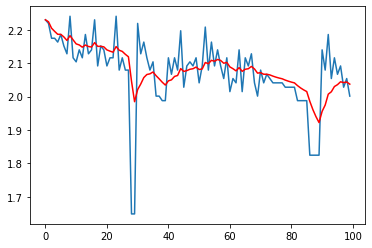

In [64]:
expwighted_avg = ts_log.ewm(span=12, adjust=True).mean()
plt.plot(ts_log)
plt.plot( expwighted_avg, color='red') 

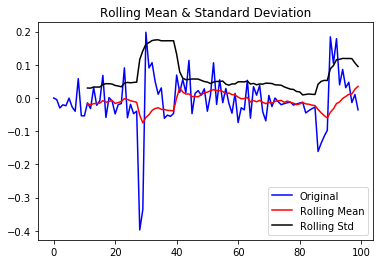

Results of Dickey-Fuller Test:
Test Statistic                -7.140928e+00
p-value                        3.325812e-10
#Lags Used                     0.000000e+00
Number of Observations Used    9.900000e+01
Critical Value (1%)           -3.498198e+00
Critical Value (5%)           -2.891208e+00
Critical Value (10%)          -2.582596e+00
dtype: float64


In [65]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

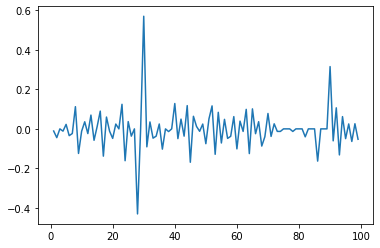

In [66]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

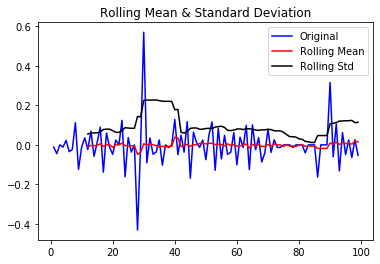

Results of Dickey-Fuller Test:
Test Statistic                -6.798883e+00
p-value                        2.263691e-09
#Lags Used                     5.000000e+00
Number of Observations Used    9.300000e+01
Critical Value (1%)           -3.502705e+00
Critical Value (5%)           -2.893158e+00
Critical Value (10%)          -2.583637e+00
dtype: float64


In [67]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

自回归模型

In [72]:
from statsmodels.tsa.arima_model import ARIMA

Text(0.5, 1.0, 'RSS: 0.9000')

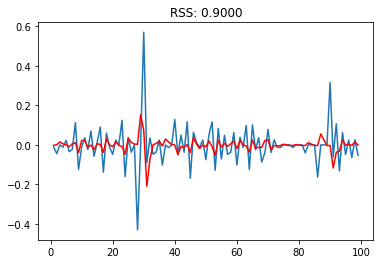

In [73]:
model_1= ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model_1.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

移动回归模型

Text(0.5, 1.0, 'RSS: 0.7670')

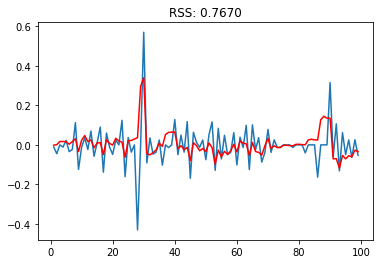

In [74]:
model_2 = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model_2.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))